In [ ]:
### --- Importacoes --- ###

import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix




In [2]:
audios_path = 'data\\nsynth-train\\audio'

In [ ]:
json_archive = 'data\\nsynth-train\examples.json'

df = pd.read_json(json_archive)

df.head(10)

In [5]:
df = df.T

In [6]:
# Conta a quantidade de amostras para cada família de instrumento
df['instrument_family_str'].value_counts()

instrument_family_str
bass          65474
keyboard      51821
organ         34477
mallet        34201
guitar        32690
string        19474
reed          13911
brass         12675
vocal         10208
flute          8773
synth_lead     5501
Name: count, dtype: int64

In [7]:
df['path'] = df['note_str'].apply(lambda name: os.path.join(audios_path, f'{name}.wav'))

In [8]:
### --- Criação de Subconjunto --- ###

#selecao de classes
selected_class = ['guitar', 'organ', 'flute', 'string', 'bass', 'reed', 'vocal', 'synth_lead', 'brass']

#criacao de df filtrado
df_filtred = df[df['instrument_family_str'].isin(selected_class)]

#definir a quantidade de amostras para cada classe
n_samples = 800

#novo df com n° de samples
mini_df = df_filtred.groupby('instrument_family_str').sample(n=n_samples, random_state=42).reset_index(drop=True)

In [9]:
### --- Checagem do novo DataFrame --- ###

print("Tamanho do novo mini-dataset:", mini_df)
print("\nDistribuição das classes no mini-dataset:")
print(mini_df['instrument_family_str'].value_counts())

Tamanho do novo mini-dataset:         note sample_rate pitch instrument_source instrument_family_str  \
0     207237       16000    24                 1                  bass   
1     282432       16000    27                 2                  bass   
2     210383       16000    74                 2                  bass   
3     199611       16000    55                 2                  bass   
4     159162       16000    58                 2                  bass   
...      ...         ...   ...               ...                   ...   
7195   28938       16000    47                 2                 vocal   
7196   59136       16000    98                 2                 vocal   
7197   37838       16000    59                 0                 vocal   
7198   31956       16000    92                 2                 vocal   
7199   12406       16000    98                 2                 vocal   

           instrument_str                     note_str  \
0     bass_electronic_0

In [ ]:
tqdm.pandas()

# Define um tamanho fixo para a dimensão de tempo dos espectrogramas
MAX_LEN = 175 

def extrair_features(file_path):
    """
    Função para carregar um arquivo de áudio, extrair o espectrograma em Mel 
    e padronizar seu tamanho para MAX_LEN.
    """
    try:
        # 1. Carrega o arquivo de áudio
        y, sr = librosa.load(file_path, sr=22050)
        
        # 2. Extrai o espectrograma em Mel
        spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
        
        # 3. Padroniza o tamanho (padding ou truncating)
        if log_spectrogram.shape[1] < MAX_LEN:
            # Se for mais curto, adiciona padding (zeros) no final
            pad_width = MAX_LEN - log_spectrogram.shape[1]
            padded_spec = np.pad(log_spectrogram, pad_width=((0, 0), (0, pad_width)), mode='constant')
            return padded_spec
        else:
            # Se for mais longo, trunca (corta) no tamanho máximo
            return log_spectrogram[:, :MAX_LEN]
            
    except Exception as e:
        print(f"Erro ao processar o arquivo {file_path}: {e}")
        return None

# --- Aplica a função a TODAS as linhas da coluna 'path' do mini_df ---
# A barra de progresso 'tqdm' mostrará o andamento.
print("Iniciando a extração de features para todo o mini-dataset...")
print("Isso pode levar alguns minutos...")

# Criamos uma nova coluna chamada 'features' para armazenar os espectrogramas processados
mini_df['features'] = mini_df['path'].progress_apply(extrair_features)

print("\nProcessamento concluído!")

# --- Verificação Final ---
print(f"Total de amostras processadas: {len(mini_df)}")

# Remove qualquer linha que possa ter falhado no processamento
mini_df.dropna(inplace=True)
print(f"Total de amostras válidas após limpeza: {len(mini_df)}")

# Verifica a forma da primeira feature para confirmar o tamanho padronizado
print(f"Forma da primeira feature extraída: {mini_df['features'].iloc[0].shape}")

c:\Users\Vitor\Desktop\USP\Redes Neurais\Projeto Final\venv-tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Iniciando a extração de features para todo o mini-dataset...
Isso pode levar alguns minutos...


100%|██████████| 7200/7200 [01:24<00:00, 84.77it/s]


Processamento concluído!
Total de amostras processadas: 7200
Total de amostras válidas após limpeza: 7200
Forma da primeira feature extraída: (128, 175)


In [ ]:
# --- Passo 1: Preparar os Dados de Entrada (Features - X) ---

# Converte a coluna 'features' (que contém os espectrogramas) em um único array NumPy
X = np.array(mini_df['features'].tolist())

# Adiciona a dimensão do "canal" no final. A CNN espera uma forma como (amostras, altura, largura, canais)
# Nossos espectrogramas são como imagens em escala de cinza, então temos 1 canal.
X = X[..., np.newaxis]


# --- Passo 2: Preparar os Rótulos (Labels - y) ---

# Pega a coluna com os nomes dos instrumentos
labels = mini_df['instrument_family_str'].values

# a) Codificação de Rótulos (Label Encoding): Transforma strings em números inteiros (guitar -> 0, bass -> 1, etc.)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)

# b) Codificação One-Hot: Transforma os inteiros em vetores binários
onehot_encoder = OneHotEncoder(sparse_output=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y = onehot_encoder.fit_transform(integer_encoded)


# --- Passo 3: Dividir os Dados em Conjuntos de Treino e Validação ---

# Divide os dados, usando 20% para validação e mantendo a proporção das classes (stratify)
X_train, X_val, y_train, y_val = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    stratify=y, # Garante que a proporção de instrumentos seja a mesma nos dois conjuntos
    random_state=42
)


# --- Verificação Final ---
print("--- Formato dos Dados Prontos para Treinamento ---")
print("Forma de X_train:", X_train.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de X_val:", X_val.shape)
print("Forma de y_val:", y_val.shape)
print("\nExemplo de um rótulo One-Hot (y_train[0]):", y_train[0])

# Opcional: Para saber qual instrumento corresponde a qual vetor One-Hot
print("\nClasses codificadas:", label_encoder.classes_)

--- Formato dos Dados Prontos para Treinamento ---
Forma de X_train: (5760, 128, 175, 1)
Forma de y_train: (5760, 9)
Forma de X_val: (1440, 128, 175, 1)
Forma de y_val: (1440, 9)

Exemplo de um rótulo One-Hot (y_train[0]): [0. 0. 0. 0. 0. 0. 0. 0. 1.]

Classes codificadas: ['bass' 'brass' 'flute' 'guitar' 'organ' 'reed' 'string' 'synth_lead'
 'vocal']


In [12]:

# Repete o último eixo (o de canais) 3 vezes
X_train_rgb = np.repeat(X_train, 3, -1)
X_val_rgb = np.repeat(X_val, 3, -1)

print("--- Formato dos Dados para Modelos Pré-treinados ---")
print("Forma de X_train_rgb:", X_train_rgb.shape)
print("Forma de X_val_rgb:", X_val_rgb.shape)

--- Formato dos Dados para Modelos Pré-treinados ---
Forma de X_train_rgb: (5760, 128, 175, 3)
Forma de X_val_rgb: (1440, 128, 175, 3)


In [ ]:
# --- Definindo a Arquitetura ---

# Pega o formato da nossa entrada (ex: 128, 175, 1)
input_shape = X_train.shape[1:] 
# Pega o número de classes (ex: 5)
num_classes = y_train.shape[1]

model_baseline = Sequential([
    Input(shape=input_shape),
    
    # Bloco Convolucional 1
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Bloco Convolucional 2
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Bloco Convolucional 3
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Camadas de Classificação
    Flatten(), # Transforma a matriz 2D em um vetor 1D
    Dense(128, activation='relu'),
    Dropout(0.5), # Técnica de regularização para evitar overfitting
    Dense(num_classes, activation='softmax') # Camada de saída com ativação softmax para classificação
])

# --- Exibir o Resumo do Modelo ---
print("--- ARQUITETURA DO MODELO BASELINE (CNN SIMPLES) ---")
model_baseline.summary()

--- ARQUITETURA DO MODELO BASELINE (CNN SIMPLES) ---
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 173, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 86, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 84, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 42, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 40, 128)       73856     
                                                                 
 ma

In [ ]:
# Este callback customizado conserta o bug de serialização do EagerTensor
class EagerTensorFixCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            for key, value in logs.items():
                # Verifica se o valor é um tensor
                if isinstance(value, tf.Tensor):
                    # Converte o tensor para um número NumPy e depois para um float/int nativo do Python
                    logs[key] = value.numpy().item()

In [ ]:


# --- Definindo a Arquitetura ---

# Pega o formato da nossa entrada RGB (ex: 128, 175, 3)
input_shape_rgb = X_train_rgb.shape[1:]

# 1. Carrega o modelo ResNet50 pré-treinado, sem a camada de classificação final
base_model_resnet = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape_rgb)

# 2. Congela os pesos da base_model. Não vamos re-treiná-la.
base_model_resnet.trainable = False

# 3. Cria nosso novo modelo em cima do ResNet50
model_intermediate = Sequential([
    Input(shape=input_shape_rgb),
    base_model_resnet,
    GlobalAveragePooling2D(), # Alternativa mais moderna ao Flatten
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# --- Exibir o Resumo do Modelo ---
print("\n--- ARQUITETURA DO MODELO INTERMEDIÁRIO (ResNet50) ---")
model_intermediate.summary()


--- ARQUITETURA DO MODELO INTERMEDIÁRIO (ResNet50) ---
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 6, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 9)                 2313      
                                                                 
Total params: 24,114,569
Trainable params: 526,857
Non-trainable

In [ ]:
# --- Definindo a Arquitetura ---

# 1. Carrega o modelo EfficientNetB0 pré-treinado
base_model_effnet = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape_rgb)

# 2. Congela os pesos
base_model_effnet.trainable = False

# 3. Cria nosso novo modelo
model_sota = Sequential([
    Input(shape=input_shape_rgb),
    base_model_effnet,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# --- Exibir o Resumo do Modelo ---
print("\n--- ARQUITETURA DO MODELO SOTA (EfficientNetB0) ---")
model_sota.summary()


--- ARQUITETURA DO MODELO SOTA (EfficientNetB0) ---
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 4, 6, 1280)       4049571   
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 256)               327936    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 9)                 2313      
                                                                 
Total params: 4,379,820
Trainable params: 330,249
Non-trainable par

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# (O código para baseline_path e intermediate_path continua o mesmo)
sota_path = 'models/sota_best.h5'

# --- Cria os callbacks ---
# (As listas callbacks_baseline e callbacks_intermediate continuam as mesmas)

# Callback para o modelo SOTA (COM A CORREÇÃO)
callbacks_sota = [
    EagerTensorFixCallback(),  # <--- ADICIONE NOSSO NOVO CALLBACK AQUI
    ModelCheckpoint(filepath=sota_path, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
]

print("Callbacks definidos com a correção para o bug do EagerTensor.")

Callbacks definidos com a correção para o bug do EagerTensor.


In [18]:
# --- Compilando cada modelo com a correção ---

print("Compilando o modelo Baseline...")
model_baseline.compile(optimizer='adam', 
                       loss='categorical_crossentropy', 
                       metrics=['accuracy'],
                       run_eagerly=False) # <--- ADICIONE AQUI

print("Compilando o modelo Intermediário (ResNet50)...")
model_intermediate.compile(optimizer='adam', 
                           loss='categorical_crossentropy', 
                           metrics=['accuracy'],
                           run_eagerly=False) # <--- ADICIONE AQUI

print("Compilando o modelo Estado da Arte (EfficientNetB0)...")
model_sota.compile(optimizer='adam', 
                   loss='categorical_crossentropy', 
                   metrics=['accuracy'],
                   run_eagerly=False) # <--- ADICIONE AQUI

print("\nModelos compilados e prontos para o treinamento!")

Compilando o modelo Baseline...
Compilando o modelo Intermediário (ResNet50)...
Compilando o modelo Estado da Arte (EfficientNetB0)...

Modelos compilados e prontos para o treinamento!


In [ ]:
# --- Define o caminho para salvar os modelos ---
# (Certifique-se de que a pasta 'models' existe no seu projeto)
baseline_path = 'models/baseline_best.h5'
intermediate_path = 'models/intermediate_best.h5'
sota_path = 'models/sota_best.h5'

# --- Cria os callbacks ---

# Callback para o modelo baseline
callbacks_baseline = [
    ModelCheckpoint(filepath=baseline_path, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
]

# Callback para o modelo intermediário
callbacks_intermediate = [
    ModelCheckpoint(filepath=intermediate_path, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
]



In [20]:
# --- Definindo parâmetros de treinamento ---
EPOCHS = 40
BATCH_SIZE = 16

# --- Treinamento do Modelo Baseline (CNN Simples) ---
print("\n--- INICIANDO TREINAMENTO DO MODELO BASELINE ---")
history_baseline = model_baseline.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_baseline
)

# --- Treinamento do Modelo Intermediário (ResNet50) ---
print("\n--- INICIANDO TREINAMENTO DO MODELO INTERMEDIÁRIO (ResNet50) ---")
history_intermediate = model_intermediate.fit(
    X_train_rgb, y_train, # <--- Usando os dados RGB
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_rgb, y_val), # <--- Usando os dados RGB
    callbacks=callbacks_intermediate
)

# # --- Treinamento do Modelo Estado da Arte (EfficientNetB0) ---
# print("\n--- INICIANDO TREINAMENTO DO MODELO SOTA (EfficientNetB0) ---")
# history_sota = model_sota.fit(
#     X_train_rgb, y_train, # <--- Usando os dados RGB
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE,
#     validation_data=(X_val_rgb, y_val), # <--- Usando os dados RGB
#     callbacks=callbacks_sota
# )

print("\n--- TREINAMENTO DE TODOS OS MODELOS CONCLUÍDO! ---")


--- INICIANDO TREINAMENTO DO MODELO BASELINE ---
Epoch 1/40
356/360 [============================>.] - ETA: 0s - loss: 2.9517 - accuracy: 0.1094
Epoch 1: val_accuracy improved from -inf to 0.11111, saving model to models\baseline_best.h5
360/360 [==============================] - 9s 14ms/step - loss: 2.9433 - accuracy: 0.1092 - val_loss: 2.1972 - val_accuracy: 0.1111
Epoch 2/40
359/360 [============================>.] - ETA: 0s - loss: 2.1975 - accuracy: 0.1065
Epoch 2: val_accuracy did not improve from 0.11111
360/360 [==============================] - 5s 14ms/step - loss: 2.1975 - accuracy: 0.1064 - val_loss: 2.1972 - val_accuracy: 0.1111
Epoch 3/40
356/360 [============================>.] - ETA: 0s - loss: 2.1976 - accuracy: 0.1022
Epoch 3: val_accuracy did not improve from 0.11111
360/360 [==============================] - 5s 14ms/step - loss: 2.1976 - accuracy: 0.1021 - val_loss: 2.1972 - val_accuracy: 0.1111
Epoch 4/40
359/360 [============================>.] - ETA: 0s - loss: 2

In [ ]:
# --- Modelo 3 (Alternativa SOTA): Transfer Learning com VGG16 ---

print("\n--- DEFININDO ARQUITETURA ALTERNATIVA SOTA (VGG16) ---")

# 1. Carrega o modelo VGG16 pré-treinado
base_model_vgg = VGG16(include_top=False, weights='imagenet', input_shape=X_train_rgb.shape[1:])

# 2. Congela os pesos
base_model_vgg.trainable = False

# 3. Cria nosso novo modelo
model_sota_vgg = Sequential([
    Input(shape=X_train_rgb.shape[1:]),
    base_model_vgg,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_sota_vgg.summary()


--- DEFININDO ARQUITETURA ALTERNATIVA SOTA (VGG16) ---
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 5, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 9)                 2313      
                                                                 
Total params: 14,848,329
Trainable params: 133,641
Non-trainable

AVALIANDO MODELO 1: BASELINE (CNN SIMPLES)


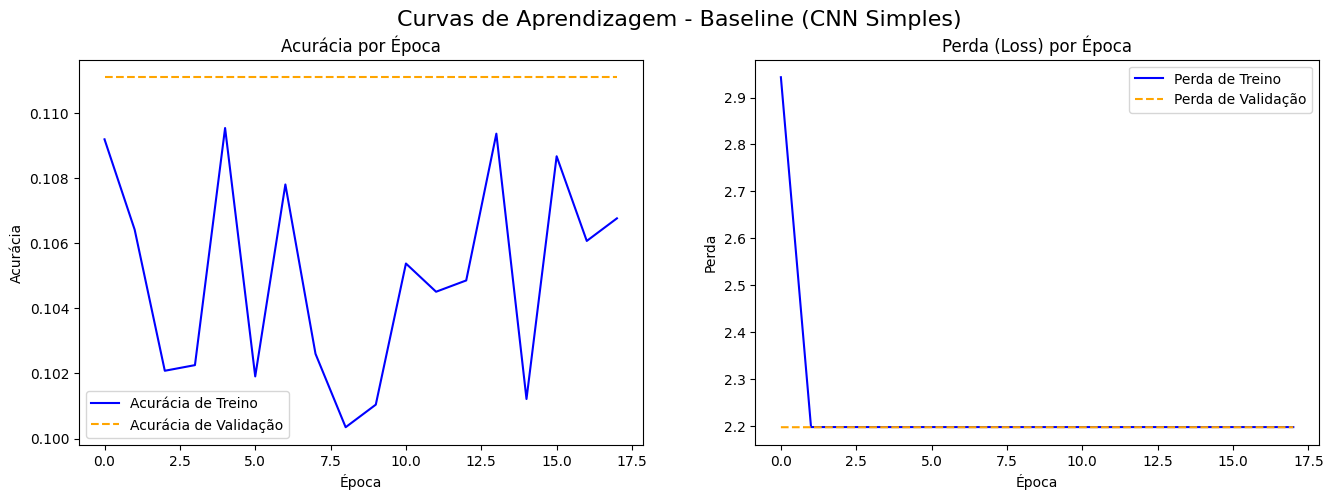

45/45 [==============================] - 1s 15ms/step

--- RELATÓRIO DE CLASSIFICAÇÃO (BASELINE) ---
              precision    recall  f1-score   support

        bass       0.11      1.00      0.20       160
       brass       0.00      0.00      0.00       160
       flute       0.00      0.00      0.00       160
      guitar       0.00      0.00      0.00       160
       organ       0.00      0.00      0.00       160
        reed       0.00      0.00      0.00       160
      string       0.00      0.00      0.00       160
  synth_lead       0.00      0.00      0.00       160
       vocal       0.00      0.00      0.00       160

    accuracy                           0.11      1440
   macro avg       0.01      0.11      0.02      1440
weighted avg       0.01      0.11      0.02      1440



c:\Users\Vitor\Desktop\USP\Redes Neurais\Projeto Final\venv-tf\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Vitor\Desktop\USP\Redes Neurais\Projeto Final\venv-tf\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Vitor\Desktop\USP\Redes Neurais\Projeto Final\venv-tf\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this b

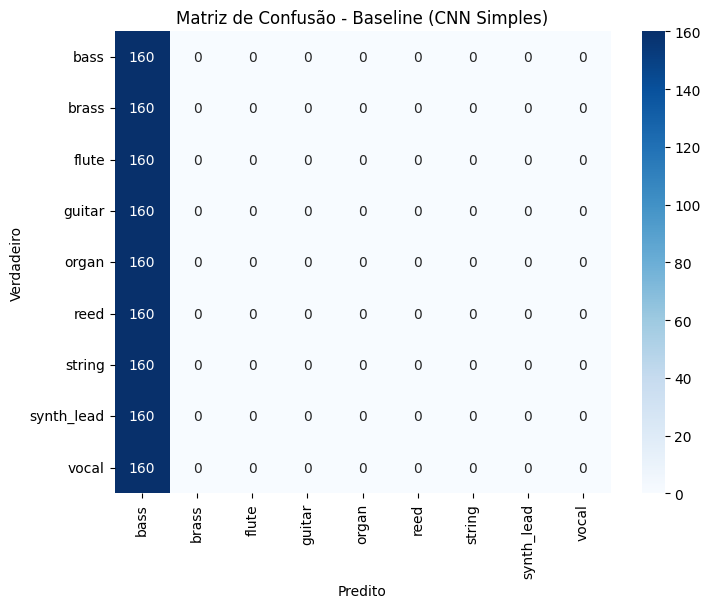



AVALIANDO MODELO 2: INTERMEDIÁRIO (ResNet50)


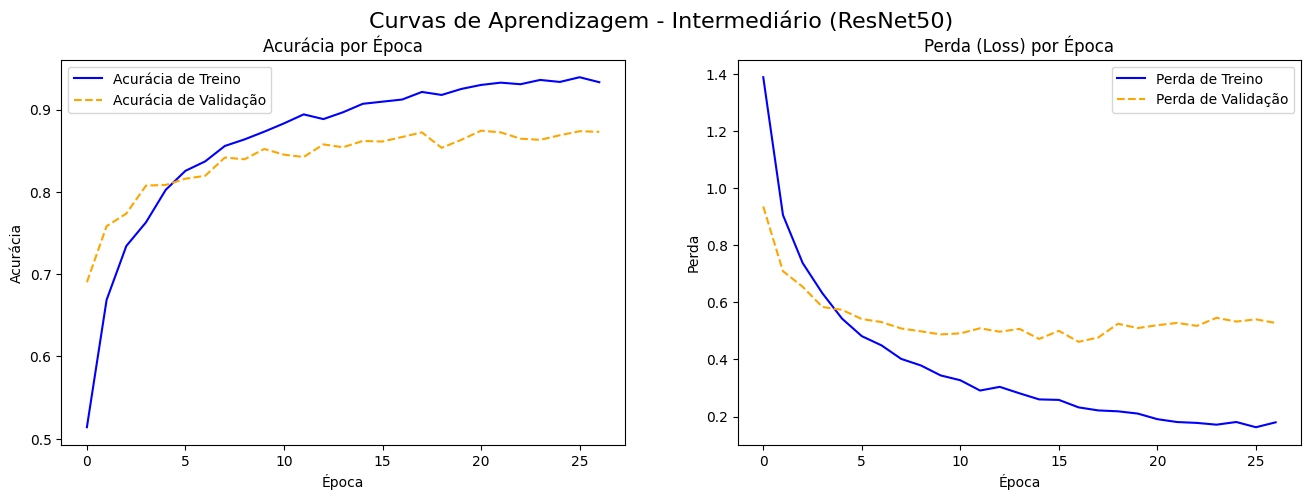

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:

# --- PRÉ-REQUISITOS ---
# Certifique-se de que os seguintes objetos existem na memória do notebook:
# history_baseline, history_intermediate, history_sota_vgg
# X_val, X_val_rgb, y_val
# label_encoder

# --- FUNÇÃO AUXILIAR PARA PLOTAR O HISTÓRICO ---
def plot_history(history, model_name):
    """Plota as curvas de acurácia e perda do treinamento."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    fig.suptitle(f'Curvas de Aprendizagem - {model_name}', fontsize=16)
    
    # Gráfico da Acurácia
    ax1.plot(history.history['accuracy'], label='Acurácia de Treino', color='blue')
    ax1.plot(history.history['val_accuracy'], label='Acurácia de Validação', color='orange', linestyle='--')
    ax1.set_title('Acurácia por Época')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Acurácia')
    ax1.legend()
    
    # Gráfico da Perda
    ax2.plot(history.history['loss'], label='Perda de Treino', color='blue')
    ax2.plot(history.history['val_loss'], label='Perda de Validação', color='orange', linestyle='--')
    ax2.set_title('Perda (Loss) por Época')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Perda')
    ax2.legend()
    
    plt.show()

# Pega o nome das classes para usar nos relatórios e gráficos
class_names = label_encoder.classes_
# Converte os rótulos de validação (one-hot) para formato de índice para as métricas
y_true = np.argmax(y_val, axis=1)

# =======================================================================================
# --- AVALIAÇÃO DO MODELO 1: BASELINE (CNN SIMPLES) ---
# =======================================================================================
print("="*60)
print("AVALIANDO MODELO 1: BASELINE (CNN SIMPLES)")
print("="*60)

# Plotar curvas de aprendizagem
plot_history(history_baseline, "Baseline (CNN Simples)")

# Carregar o melhor modelo salvo
model_b = load_model('models/baseline_best.h5')

# Fazer predições no conjunto de validação
y_pred_b = model_b.predict(X_val)
y_pred_classes_b = np.argmax(y_pred_b, axis=1)

# Relatório de Classificação
print("\n--- RELATÓRIO DE CLASSIFICAÇÃO (BASELINE) ---")
print(classification_report(y_true, y_pred_classes_b, target_names=class_names))

# Matriz de Confusão
cm_b = confusion_matrix(y_true, y_pred_classes_b)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_b, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusão - Baseline (CNN Simples)')
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.show()


# =======================================================================================
# --- AVALIAÇÃO DO MODELO 2: INTERMEDIÁRIO (ResNet50) ---
# =======================================================================================
print("\n\n" + "="*60)
print("AVALIANDO MODELO 2: INTERMEDIÁRIO (ResNet50)")
print("="*60)

# Plotar curvas de aprendizagem
plot_history(history_intermediate, "Intermediário (ResNet50)")

# Carregar o melhor modelo salvo
model_i = load_model('models/intermediate_best.h5')

# Fazer predições no conjunto de validação (lembre-se de usar X_val_rgb)
y_pred_i = model_i.predict(X_val_rgb)
y_pred_classes_i = np.argmax(y_pred_i, axis=1)

# Relatório de Classificação
print("\n--- RELATÓRIO DE CLASSIFICAÇÃO (INTERMEDIÁRIO) ---")
print(classification_report(y_true, y_pred_classes_i, target_names=class_names))

# Matriz de Confusão
cm_i = confusion_matrix(y_true, y_pred_classes_i)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_i, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusão - Intermediário (ResNet50)')
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.show()


# =======================================================================================
# --- AVALIAÇÃO DO MODELO 3: SOTA ALTERNATIVO (VGG16) ---
# =======================================================================================
# print("\n\n" + "="*60)
# print("AVALIANDO MODELO 3: SOTA ALTERNATIVO (VGG16)")
# print("="*60)


# # Carregar o melhor modelo salvo
# model_s = load_model('models/sota_best.h5')

# # Fazer predições no conjunto de validação (lembre-se de usar X_val_rgb)
# y_pred_s = model_s.predict(X_val_rgb)
# y_pred_classes_s = np.argmax(y_pred_s, axis=1)

# # Relatório de Classificação
# print("\n--- RELATÓRIO DE CLASSIFICAÇÃO (SOTA) ---")
# print(classification_report(y_true, y_pred_classes_s, target_names=class_names))

# # Matriz de Confusão
# cm_s = confusion_matrix(y_true, y_pred_classes_s)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm_s, annot=True, fmt='d', cmap='Oranges', xticklabels=class_names, yticklabels=class_names)
# plt.title('Matriz de Confusão - SOTA (VGG16)')
# plt.ylabel('Verdadeiro')
# plt.xlabel('Predito')
# plt.show()

In [31]:
import librosa
import numpy as np
from tensorflow.keras.models import load_model

# --- CONSTANTES DE PRÉ-PROCESSAMENTO (Devem ser as mesmas do treinamento) ---
MAX_LEN = 175 
SAMPLE_RATE = 22050
N_MELS = 128

def processar_audio_para_predicao(file_path):
    """
    Carrega e processa um único arquivo de áudio, transformando-o em um 
    espectrograma padronizado, pronto para o modelo.
    """
    try:
        # 1. Carrega o arquivo de áudio
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
        
        # 2. Extrai o espectrograma em Mel
        spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
        log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
        
        # 3. Padroniza o tamanho (padding ou truncating)
        if log_spectrogram.shape[1] < MAX_LEN:
            pad_width = MAX_LEN - log_spectrogram.shape[1]
            padded_spec = np.pad(log_spectrogram, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            padded_spec = log_spectrogram[:, :MAX_LEN]
            
        # 4. Adiciona a dimensão do "canal" no final
        return padded_spec[..., np.newaxis]
            
    except Exception as e:
        print(f"Erro ao processar o arquivo {file_path}: {e}")
        return None

def prever_instrumento(audio_path, label_encoder_obj):
    """
    Função principal que recebe o caminho de um arquivo de áudio e
    imprime a predição dos três modelos treinados.
    """
    # Processa o áudio para o formato de entrada da rede
    processed_audio = processar_audio_para_predicao(audio_path)
    
    if processed_audio is None:
        return

    print(f"--- ANALISANDO O ARQUIVO: {os.path.basename(audio_path)} ---")
    
    # Prepara os dados para os modelos pré-treinados (formato RGB)
    processed_audio_rgb = np.repeat(processed_audio, 3, -1)
    
    # Adiciona a dimensão do "lote" (batch)
    input_baseline = np.expand_dims(processed_audio, axis=0)
    input_rgb = np.expand_dims(processed_audio_rgb, axis=0)

    # --- Carrega os modelos e faz as predições ---
    
    # Modelo 1: Baseline
    model_b = load_model('models/baseline_best.h5')
    pred_b = model_b.predict(input_baseline)
    class_b = label_encoder_obj.classes_[np.argmax(pred_b[0])]
    conf_b = np.max(pred_b[0])
    
    # Modelo 2: ResNet50
    model_i = load_model('models/intermediate_best.h5')
    pred_i = model_i.predict(input_rgb)
    class_i = label_encoder_obj.classes_[np.argmax(pred_i[0])]
    conf_i = np.max(pred_i[0])
    
    
    # Imprime os resultados
    print("\n--- RESULTADOS DA PREDIÇÃO ---")
    print(f"Modelo Baseline (CNN Simples): {class_b.upper()} (Confiança: {conf_b:.2%})")
    print(f"Modelo Intermediário (ResNet50): {class_i.upper()} (Confiança: {conf_i:.2%})")


# --- COLOQUE O CAMINHO DO SEU ARQUIVO DE ÁUDIO AQUI ---
# Lembre-se de usar barras normais '/' ou barras duplas '\\' no Windows

caminho_do_meu_audio = "data\\nsynth-test\\audio\\string_acoustic_012-049-025.wav" 

# Chama a função para fazer a mágica
# (A variável 'label_encoder' deve existir na memória do seu notebook, da fase de preparação de dados)
prever_instrumento(caminho_do_meu_audio, label_encoder)

--- ANALISANDO O ARQUIVO: string_acoustic_012-049-025.wav ---


ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[35840,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessRandomUniformV2]